<a href="https://colab.research.google.com/github/shuuuuyu/113-2-Generative-AI/blob/main/assignment_7_%E5%AF%A6%E4%BD%9CRAG%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 我的AI自主學習輔導員可以扮演類似「助教」的角色，能根據學生輸入的筆記內容或問題，給予親切、清楚且具體的回應與建議。
- 目前使用的資料是另一堂課(交大的人工智慧與深度學習)的我的上課筆記:
    - https://drive.google.com/file/d/1B1mO4VKjdFp5lx_5UNIOR7fgN7JbndrK/view?usp=sharing

- 畫面截圖
    - 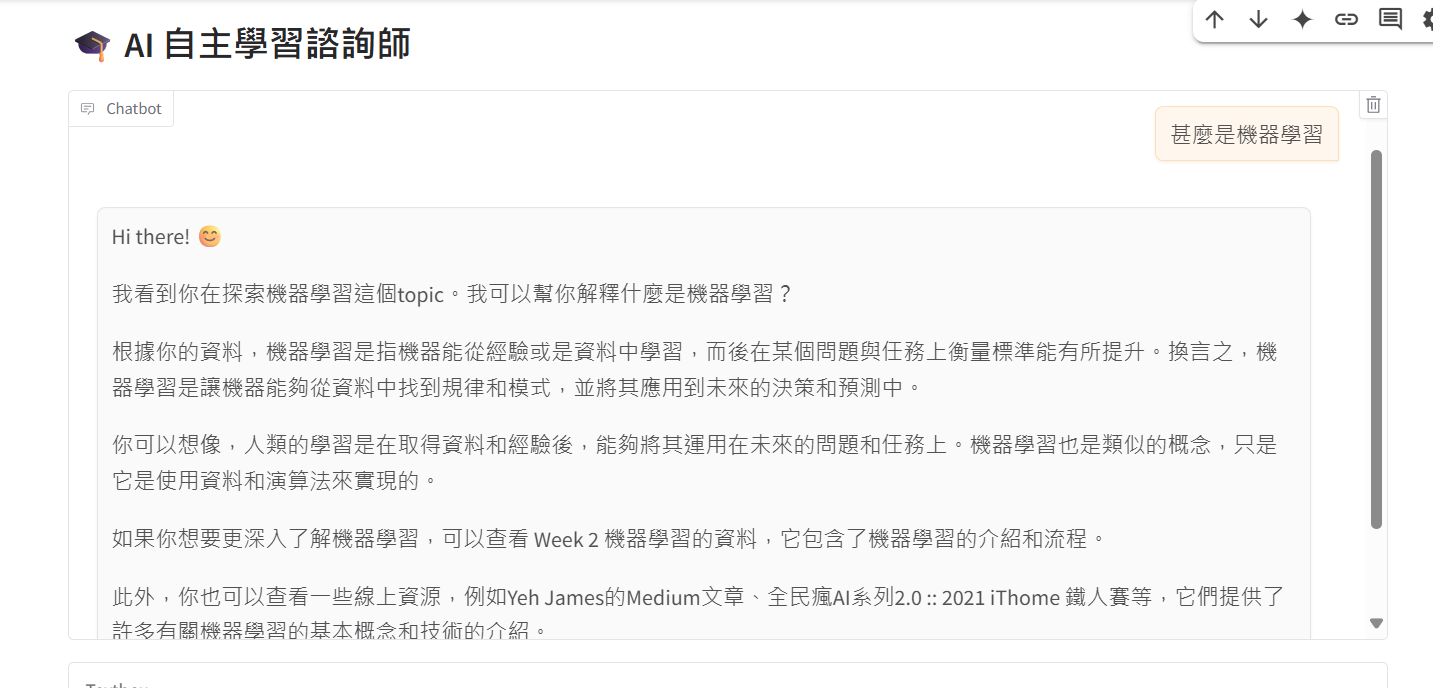
    - 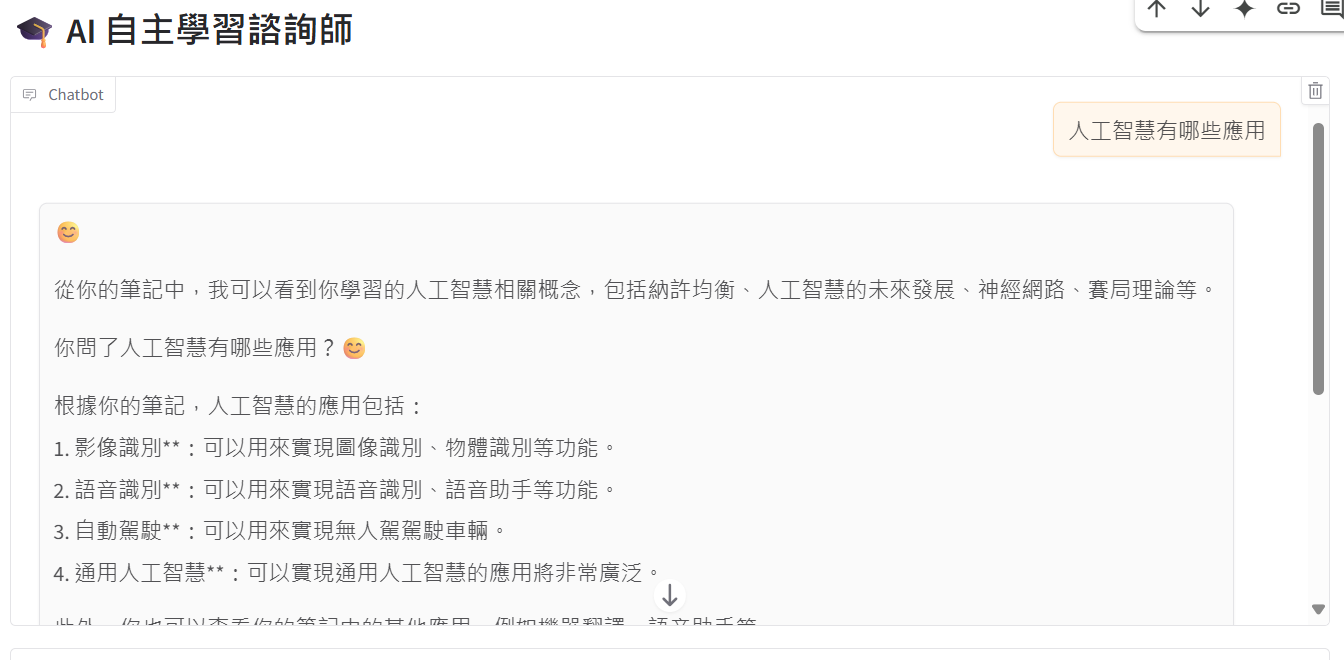

In [85]:
URL = "https://drive.google.com/uc?export=download&id=1bD_D5yJyGBWIhAflqraW3uVamVOGuAMN"
!wget -O faiss_db.zip "$URL"

--2025-06-03 09:12:29--  https://drive.google.com/uc?export=download&id=1bD_D5yJyGBWIhAflqraW3uVamVOGuAMN
Resolving drive.google.com (drive.google.com)... 142.250.157.138, 142.250.157.113, 142.250.157.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.157.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1bD_D5yJyGBWIhAflqraW3uVamVOGuAMN&export=download [following]
--2025-06-03 09:12:29--  https://drive.usercontent.google.com/download?id=1bD_D5yJyGBWIhAflqraW3uVamVOGuAMN&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.125.132, 2404:6800:4008:c13::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75488 (74K) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]  73.72K  --.-KB/

In [86]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
replace faiss_db/index.faiss? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: faiss_db/index.faiss    
  inflating: faiss_db/index.pkl      


### 1. 安裝並引入必要套件

In [ ]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

In [88]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [89]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [90]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [91]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

### 4. 設定好我們要的 LLM

In [92]:
import os
from google.colab import userdata

如之前, 我們會用 OpenAI API。這裡使用 Groq 服務, 可改成你要的服務。

In [93]:
api_key = userdata.get('Groq')

In [94]:
os.environ["OPENAI_API_KEY"] = api_key

這裡的模型和 `base_url` 是用 Groq, 如果用其他服務請自行修改。

In [95]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [96]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

### 5. `prompt` 設計

In [97]:
system_prompt = """
你是人工智慧與深度學習課程的 AI 自主學習輔導員，主要任務是協助學生理解課程內容與解決學習問題。
請根據學生提供的筆記內容回應，風格需親切、簡潔，並附上具體可行的學習建議。
回覆語言為台灣常用的中文，避免艱澀術語，必要時請舉例幫助理解。
請協助學生釐清觀念、補充知識、提出延伸學習方向，必要時可建議相關資源（如影片、文章或練習題）。
若學生的問題不明確，可先引導學生說明目前卡關的部分。
務必只使用繁體中文回答
"""
prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴同學可以上網查詢更多資料。
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [98]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [101]:
with gr.Blocks() as demo:
    gr.Markdown("# 🎓 AI 自主學習諮詢師")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-101-a12785d21538>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://666a624db5789260b3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://666a624db5789260b3.gradio.live
